In [1]:
#inicializar a sessao spark

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .config("spark.ui.port", "4041") \
    .getOrCreate()

In [2]:
# preview data

import pyarrow.parquet as pq

# Load the Parquet file metadata
parquet_file = pq.ParquetFile('yellow_tripdata_2025-01.parquet')

# Print schema (column names and types)
print(parquet_file.schema)

required group field_id=-1 schema {
  optional int32 field_id=-1 VendorID;
  optional int64 field_id=-1 tpep_pickup_datetime (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional int64 field_id=-1 tpep_dropoff_datetime (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional int64 field_id=-1 passenger_count;
  optional double field_id=-1 trip_distance;
  optional int64 field_id=-1 RatecodeID;
  optional binary field_id=-1 store_and_fwd_flag (String);
  optional int32 field_id=-1 PULocationID;
  optional int32 field_id=-1 DOLocationID;
  optional int64 field_id=-1 payment_type;
  optional double field_id=-1 fare_amount;
  optional double field_id=-1 extra;
  optional double field_id=-1 mta_tax;
  optional double field_id=-1 tip_amount;
  optional double field_id=-1 tolls_amount;
  optional double field_id=-1 improvement_surcharge;
  op

In [3]:
import pandas as pd

# Example with pyarrow or fastparquet (it will choose the engine automatically if both are available)
df_o = pd.read_parquet('yellow_tripdata_2025-01.parquet')

# If you want to explicitly specify the engine:
# df = pd.read_parquet('your_file.parquet', engine='pyarrow')
# df = pd.read_parquet('your_file.parquet', engine='fastparquet')

print(df_o.head())


   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2025-01-01 00:18:38   2025-01-01 00:26:59              1.0   
1         1  2025-01-01 00:32:40   2025-01-01 00:35:13              1.0   
2         1  2025-01-01 00:44:04   2025-01-01 00:46:01              1.0   
3         2  2025-01-01 00:14:27   2025-01-01 00:20:01              3.0   
4         2  2025-01-01 00:21:34   2025-01-01 00:25:06              3.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.60         1.0                  N           229           237   
1           0.50         1.0                  N           236           237   
2           0.60         1.0                  N           141           141   
3           0.52         1.0                  N           244           244   
4           0.66         1.0                  N           244           116   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [4]:
# usar spark data_frame

df = spark.read.parquet("yellow_tripdata_2025-01.parquet")
df.printSchema()
df.show(5)
df.count()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------

3475226

In [5]:
#preprocessing step

from pyspark.sql.functions import col, hour, dayofweek, unix_timestamp, when
from pyspark.sql.types import DoubleType

#eliminar linhas que tenham zeros em alguma coluna
required_columns = [
    "trip_distance", "passenger_count", "tpep_pickup_datetime", "tpep_dropoff_datetime", 
    "VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type", 
    "PULocationID", "DOLocationID", "fare_amount"
]

df = df.dropna(subset=required_columns)

# Convert timestamp columns to datetime and extract useful features
df = df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
df = df.withColumn("pickup_dayofweek", dayofweek(col("tpep_pickup_datetime")))

# Trip duration in minutes
df = df.withColumn("trip_duration", 
                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

# Drop rows with nulls in relevant columns
df = df.dropna(subset=["fare_amount", "trip_distance", "trip_duration", "pickup_hour", "pickup_dayofweek"])

# Create a new feature fare_per_km

df = df.withColumn("fare_per_km", col("fare_amount") / (col("trip_distance") + 1e-3))

# Create new feature - rush hour

df = df.withColumn(
    "is_rush_hour",
    when(
        ((col("pickup_hour") >= 4) & (col("pickup_hour") <= 5)) |
        ((col("pickup_hour") >= 16) & (col("pickup_hour") <= 18)),
        1
    ).otherwise(0)
)

# Create new feature - is_weekend

df = df.withColumn(
    "is_weekend",
    when(
        (col("pickup_dayofweek") == 1) | (col("pickup_dayofweek") == 7),
        1
    ).otherwise(0)
)


#remove situations where values may be wrong
#negative values
#very high fares
#df = df.filter((col("fare_amount") >= 0) & (col("fare_amount") <= 100))

df_filtered = df.filter(
    (col("fare_amount") > 0) &
    (col("fare_amount") < 200) &
    (col("trip_distance") > 0) &
    (col("tip_amount") >= 0) &
    (col("fare_per_km") < 50)
)



In [6]:
#feature engineering + encoding

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Categorical features to encode
categorical_cols = ["VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type", "PULocationID", "DOLocationID"]
#indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid='keep') for col in categorical_cols]
#encoders = [OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe") for col in categorical_cols]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid='keep') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe", handleInvalid='keep') for col in categorical_cols]

# Features to include
feature_cols = ["trip_distance", "passenger_count", "fare_amount", "pickup_hour", "pickup_dayofweek", "trip_duration","is_rush_hour", "is_weekend"] + \
               [col+"_ohe" for col in categorical_cols]

# Assemble features
#assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid='skip')  # or 'keep'

# Create pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df_filtered)
df_prepared = pipeline_model.transform(df_filtered)

assembler_inputs = [
    "trip_distance", "passenger_count", "pickup_hour", "pickup_dayofweek", "trip_duration"
] + [col + "_ohe" for col in categorical_cols]

df_prepared = df_prepared.dropna(subset=assembler_inputs)



In [7]:
# train regressor model

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# Train/test split
train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

# Define model
rf = RandomForestRegressor(featuresCol="features", labelCol="tip_amount")

# Optional: tune hyperparameters
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5,10]) \
    .addGrid(rf.numTrees, [20,50]) \
    .build()

# TrainValidationSplit (simpler than CrossValidator)
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction", metricName="rmse"),
                           trainRatio=0.8)

model = tvs.fit(train_df)


In [8]:
# evaluate model

# Apply model
predictions = model.transform(test_df)

# Evaluate
evaluator = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction")

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")


RMSE: 2.12
MAE: 1.02
R2: 0.68


In [9]:
df_filtered.select("tip_amount").summary("mean", "min", "max").show()


+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|   mean|3.4881408254613624|
|    min|               0.0|
|    max|             400.0|
+-------+------------------+



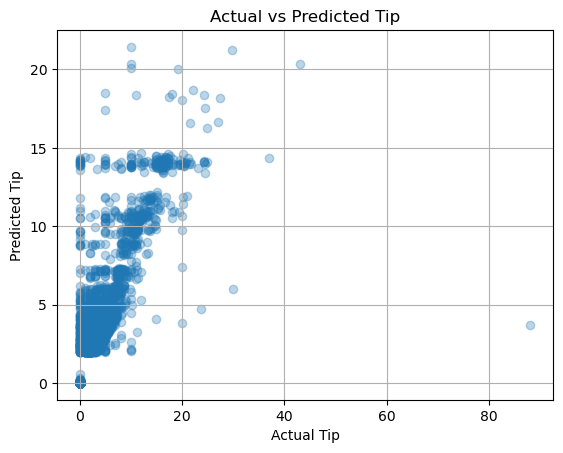

In [10]:
sample = predictions.select("tip_amount", "prediction").sample(False, 0.01).toPandas()

import matplotlib.pyplot as plt
plt.scatter(sample["tip_amount"], sample["prediction"], alpha=0.3)
plt.xlabel("Actual Tip")
plt.ylabel("Predicted Tip")
plt.title("Actual vs Predicted Tip")
plt.grid(True)
plt.show()


In [11]:
df_filtered.select("tip_amount").summary("min", "max", "mean", "stddev").show()


+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|    min|               0.0|
|    max|             400.0|
|   mean|3.4881408254613624|
| stddev|3.7523591565725205|
+-------+------------------+



In [12]:
rf_model = model.bestModel
print(rf_model.featureImportances)


(541,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,20,21,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,99,100,101,103,104,105,106,107,110,111,112,113,114,115,116,117,118,119,121,123,124,125,127,128,129,130,131,134,135,136,139,140,141,144,145,146,150,152,154,157,158,160,164,168,171,173,175,176,181,184,193,196,197,198,205,206,208,212,214,218,221,227,230,232,233,234,241,250,251,254,255,257,261,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,38

In [13]:
model.bestModel.save("tip_prediction_model")


In [14]:
# Get trained model
rf_model = model.bestModel

# Get feature names (from VectorAssembler)
feature_names = assembler.getInputCols()

# Get importance scores
importances = rf_model.featureImportances

# Convert to readable list
importance_list = list(zip(feature_names, importances.toArray()))
sorted_importance = sorted(importance_list, key=lambda x: x[1], reverse=True)

# Print nicely
print("Feature Importances:")
for feature, importance in sorted_importance:
    print(f"{feature:<30} {importance:.4f}")


Feature Importances:
fare_amount                    0.3052
trip_distance                  0.1404
trip_duration                  0.1083
DOLocationID_ohe               0.0270
PULocationID_ohe               0.0158
pickup_hour                    0.0029
VendorID_ohe                   0.0026
RatecodeID_ohe                 0.0025
passenger_count                0.0005
is_rush_hour                   0.0005
pickup_dayofweek               0.0005
is_weekend                     0.0003
store_and_fwd_flag_ohe         0.0000
payment_type_ohe               0.0000


In [15]:
#close spark session

#spark.stop()